In [1]:
# Imports
import os
import clr
import sys
from imp import reload
from System import Array
from time import sleep, time
import numpy as np
from matplotlib import pyplot as plt
from scipy.misc import factorial
import peakutils
# sys.path.append(os.getcwd())
%matplotlib inline

import qcodes as qc
qc.show_subprocess_widget()

import qcodes.instrument.parameter as parameter

loc_provider = qc.data.location.FormatLocation(fmt='data/{date}/#{counter}_{name}_{time}')
qc.data.data_set.DataSet.location_provider=loc_provider

<IPython.core.display.Javascript object>

In [2]:
def try_close_instruments(instruments=['PulseBlaster', 'ArbStudio', 'SIM900', 'ATS', 'ATS_controller']):
    if isinstance(instruments, str):
        instruments = [instruments]
    for instrument in instruments:
        try:
            eval('{}.close()'.format(instrument_name))
        except:
            pass
        
def plot_traces(traces, traces_AWG=None):
    plt.figure()
    plt.pcolormesh(range(traces.shape[1]), 
                 range(traces.shape[0]+1), traces)
    if traces_AWG is not None:
        trace_AWG = traces_AWG[:1]
        trace_AWG /= (np.max(trace_AWG)-np.min(trace_AWG))
        trace_AWG -= np.min(trace_AWG)
        plt.pcolormesh(range(traces.shape[1]), 
                       np.array([0,1])+traces.shape[0], trace_AWG)
    plt.xlim([0,traces.shape[1]])
    plt.ylim([0,traces.shape[0]+1])
    plt.colorbar()

    fig, axes = plt.subplots(len(traces), sharex=True)
    for k, trace in enumerate(traces):
        axes[k].plot(trace)
        axes[k].plot(trace > 0.5)
        if traces_AWG is not None:
            trace_AWG = traces_AWG[k]
            trace_AWG /= (np.max(trace_AWG)-np.min(trace_AWG))
            trace_AWG -= np.min(trace_AWG)
            axes[k].plot(trace_AWG)
        else:
            axes[k].plot([1]*load_pts+[0.5]*read_pts+[0]*empty_pts)
    
dummy_param = parameter.ManualParameter(name="dummy", initial_value=42)

In [3]:
# Load instruments
import qcodes.instrument_drivers.lecroy.ArbStudio1104 as ArbStudio_driver
import qcodes.instrument_drivers.spincore.PulseBlasterESRPRO as PulseBlaster_driver
import qcodes.instrument_drivers.stanford_research.SIM900 as SIM900_driver
from meta_instruments import Analysis

for instrument_name in ['ArbStudio', 'PulseBlaster', 'SIM900']:
    try_close_instruments(instrument_name)
    eval('reload({}_driver)'.format(instrument_name))
try_close_instruments('erl_analysis')
reload(Analysis)

dll_path = os.path.join(os.getcwd(),'lecroy_driver\\Library\\ArbStudioSDK.dll')
ArbStudio = ArbStudio_driver.ArbStudio1104('ArbStudio', dll_path, server_name=None)

PulseBlaster = PulseBlaster_driver.PulseBlaster('PulseBlaster', server_name='PB_server')

SIM900 = SIM900_driver.SIM900('SIM900', 'GPIB0::4::INSTR')
TG, LB, RB, TGAC, SRC, NOTUSED, DS, DF = [eval('SIM900.chan{}'.format(i)) for i in range(1,9)]


In [4]:
# Load ATS instruments
import qcodes.instrument_drivers.AlazarTech.ATS9440 as ATS_driver
import qcodes.instrument_drivers.AlazarTech.ATS_acquisition_controllers as ATS_controller_driver
# import qcodes.personal.meta_instruments.

for instrument_name in ['ATS', 'ATS_controller']:
    try_close_instruments(instrument_name)
    eval('reload({}_driver)'.format(instrument_name))
ATS = ATS_driver.ATS9440('ATS', server_name='Alazar_server')
ATS_controller = ATS_controller_driver.Average_AcquisitionController(name='ATS_control', 
                                                           alazar_name='ATS',
                                                           server_name='Alazar_server')

#Default ATS and ATS_controller settings
# Configure ATS and ATS_controller
ATS.config(trigger_source1='CHANNEL_C',
           trigger_level1=120,
           trigger_slope1='TRIG_SLOPE_NEGATIVE',
           channel_range=2,
           sample_rate=1e6,
           coupling='DC')

ATS_controller.update_acquisition_kwargs(buffer_timeout=5000,
                                         samples_per_record=10000,
                                         records_per_buffer=1,
                                         buffers_per_acquisition=4,
                                         channel_selection='AC')
erl_analysis = Analysis.EmptyLoadReadAnalysis(name='ELR_analysis', ATS_controller=ATS_controller)

# Configure pulses

In [20]:
def configure_PulseBlaster(PulseBlaster, durations, marker_cycles=100, sampling_rate=500):
    # Factor of 2 needed because apparently the core clock is not the same as the sampling rate
    ms = 2 * sampling_rate * 1e3

    PulseBlaster.detect_boards()
    PulseBlaster.select_board(0)
    PulseBlaster.core_clock(sampling_rate)

    PulseBlaster.start_programming()
    
    pulse = 'empty'
    PulseBlaster.send_instruction(0,'continue',0, marker_cycles)
    start = PulseBlaster.send_instruction(0, 'continue', 0, durations[pulse]*ms - marker_cycles)
    
    pulse = 'load'
    PulseBlaster.send_instruction(1,'continue',0, marker_cycles)
    PulseBlaster.send_instruction(0, 'continue', start, durations[pulse]*ms - marker_cycles)
    
    pulse = 'read'
    PulseBlaster.send_instruction(1,'continue',0, marker_cycles)
    PulseBlaster.send_instruction(0, 'continue', 0, durations[pulse]*ms - marker_cycles)
    
    pulse = 'final_delay'
    if durations[pulse] > 0:
        PulseBlaster.send_instruction(0, 'continue', 0, durations[pulse]*ms)
    PulseBlaster.send_instruction(1,'branch',start, marker_cycles)
    
    PulseBlaster.stop_programming()
    
def configure_ArbStudio(ArbStudio, voltages, channel_factors, marker_cycles=100):
    stages = ['empty', 'load', 'read']
    for ch in [1,2,3,4]:
        eval('ArbStudio.ch{}_clear_waveforms()'.format(ch))
    for ch in [1, 2, 3]:
        eval("ArbStudio.ch{}_trigger_source('fp_trigger_in')".format(ch))
        eval("ArbStudio.ch{}_trigger_mode('stepped')".format(ch))
        eval('ArbStudio.ch{}_clear_waveforms()'.format(ch))
        waveforms = channel_factors[ch-1] * np.array([[voltages[stage]]*4 for stage in stages])
        for waveform in waveforms:
            eval('ArbStudio.ch{}_add_waveform(waveform)'.format(ch))

        eval('ArbStudio.ch{}_sequence([0, 1, 2])'.format(ch))
    waveforms = ArbStudio.load_waveforms(channels=[1,2,3])
    sequences = ArbStudio.load_sequence(channels=[1,2,3])
    return waveforms, sequences
def configure_ATS_controller(ATS_controller, durations, samples=200):
    stages = ['empty', 'load', 'read']
    read_length = sum([durations[stage] for stage in stages])
    sample_rate = ATS_controller._get_alazar_parameter('sample_rate')
    samples_per_record = int(16 * round(float(sample_rate*read_length*1e-3)/16))
    
    ATS_controller.average_mode('none')
    ATS_controller.update_acquisition_kwargs(samples_per_record=samples_per_record,
                                             records_per_buffer=1,
                                             buffers_per_acquisition=samples)

In [23]:
compensation_factor = -1.5
channel_factors = [1, compensation_factor, 1]
voltages = {'empty': -1.5, 'load': 1.5, 'read': 0}
durations = {'empty': 5, 'load': 5, 'read': 20, 'final_delay': 0.1}

erl_analysis.empty_duration(durations['empty'])
erl_analysis.load_duration(durations['load'])
erl_analysis.read_duration(durations['read'])

configure_PulseBlaster(PulseBlaster, durations)
configure_ArbStudio(ArbStudio, voltages, channel_factors)
configure_ATS_controller(ATS_controller, durations, samples=100)

In [26]:
ArbStudio.run(channels=[1,2,3])
sleep(1)
PulseBlaster.start()

%timeit traces, traces_AWG = ATS_controller.acquisition()

ArbStudio.stop()
PulseBlaster.stop()

1 loop, best of 3: 3.25 s per loop


0

In [27]:
ArbStudio.stop()
ArbStudio.run(channels=[1,2,3])
sleep(.1)

PulseBlaster.start()

%timeit erl_analysis.fidelity()
ArbStudio.stop()
PulseBlaster.stop()

1 loop, best of 3: 3.38 s per loop


0

In [14]:
m = np.array([])
m2 = np.array([1,2,3])
m2[m] if m else []

[]

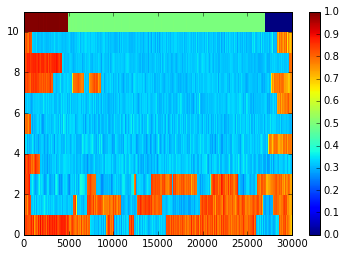

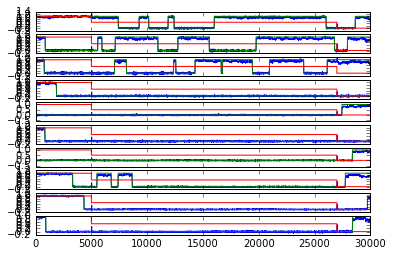

In [27]:
plot_traces(traces, traces_AWG)

0